In [8]:
from functools import partial
from itertools import product
import graspy as gp
from graspy.simulations import er_np, sbm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from twins import load_dataset
%matplotlib inline


from src.features import graph_features 

import networkx as nx
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

In [94]:
graphs = load_dataset(modality='dmri', parcellation='desikan', preprocess=None, ptr=None)[0]

df = pd.read_csv('../../../../twins/data/raw/unrestricted_jaewonc78_1_20_2019_23_7_58.csv')

gender = []
for sub in graphs.keys():
    gender.append(df[df.Subject == int(sub)]['Gender'].values[0])
gender = np.array(gender)

le = LabelEncoder()
labels = le.fit_transform(gender)
# 0 is female, 1 is male

node_df = pd.read_csv("../../../data/desikan_labels.csv")
node_df = node_df.sort_values('name')
regions = node_df.region.values

In [7]:
all_graphs = [g for _, g in graphs.items()]

In [145]:
def compute_features(graph):
    A = gp.utils.binarize(graph)
    G = nx.Graph(A)
    functions = [f for name, f in graph_features.__dict__.items() if (callable(f)) & ('small_world' not in name)]
    
    data = [f(G) for f in functions]
    return data

def project_graphs(graph, labels):
    uniques = pd.unique(labels)
    out = np.zeros((uniques.size, uniques.size))
    
    for i, row in enumerate(uniques):
        for j, col in enumerate(uniques):
            row_idx = (labels == row) * 1
            col_idx = (labels == col) * 1
            out[i, j] = graph[row_idx, col_idx].sum()
            
    return out


def project_graphs2(graph, labels):
    uniques = pd.unique(labels)
    
    # g = gp.utils.pass_to_ranks(graph, 'zero-boost')
    out = np.zeros((uniques.size, uniques.size))
    
    for i, row in enumerate(uniques):
        for j, col in enumerate(uniques):
            row_idx = (labels == row) * 1
            col_idx = (labels == col) * 1
            out[i, j] = graph[row_idx, col_idx].mean()
    
    out = gp.utils.pass_to_ranks(out, 'zero-boost')

            
    return out

In [146]:
projected_graphs2 = [project_graphs2(g, regions) for _, g in graphs.items()]

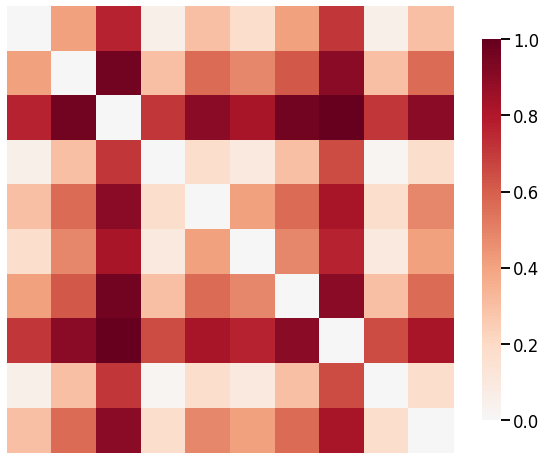

In [148]:
gp.plot.heatmap(projected_graphs2[1])

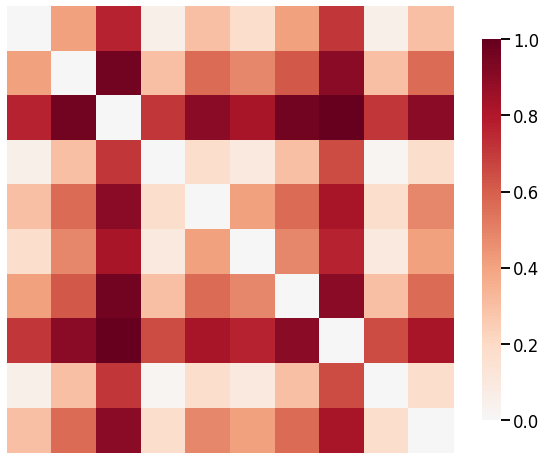

In [147]:
gp.plot.heatmap(projected_graphs2[0])

In [75]:
thresholded_graphs2 = (np.array(projected_graphs2) >  np.median(projected_graphs2)) * 1

In [88]:
outputs = Parallel(n_jobs=-1, 
                   verbose=2, 
                   #require="sharedmem"
                  )(delayed(compute_features)(g) for _, g in graphs.items())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 984 out of 984 | elapsed:   53.1s finished


In [96]:
df = pd.DataFrame(outputs, columns = names)
df.head()

,num_edges,is_planar,is_connected,total_triangles,triangle_ratio,avg_shortest_path_length,global_clustering_coefficient,avg_clustering_coefficient,diameter,square_clustering,degree_assortativity,density,node_connectivity,global_efficiency,local_efficiency,modularity
0,1018,False,True,22260,0.135550,1.625259,0.684144,0.738738,3,0.184212,0.041675,0.421532,7,0.702968,0.868935,0.262361
1,1102,False,True,26031,0.158513,1.555694,0.675428,0.749219,3,0.188555,-0.066543,0.456315,8,0.726156,0.874229,0.252493
2,1126,False,True,28260,0.172086,1.556108,0.689824,0.725393,3,0.180473,0.021641,0.466253,6,0.729400,0.862498,0.149766
3,1011,False,True,21726,0.132298,1.631056,0.676970,0.739187,3,0.177487,0.040863,0.418634,8,0.701035,0.869180,0.287077
4,1165,False,True,30147,0.183577,1.537888,0.695946,0.750134,3,0.213338,-0.025803,0.482402,6,0.737819,0.874905,0.220679


In [150]:
ORDERING = dict(
    # num_edges = "# Edges",
    #density="Density",
    # total_triangles = '# Triangles',
    #triangle_ratio="Triangle Ratio",
    # is_planar="Is Planar Graph?",
    avg_shortest_path_length="Avg Shortest Path",
    global_clustering_coefficient="Global Clustering",
    avg_clustering_coefficient="Avg Clustering",
    # square_clustering="Square Clustering",
    global_efficiency="Global Efficiency",
    local_efficiency="Local Efficiency",
    # degree_assortativity = "Degree Assortativity",
    # diameter = 'Diameter',
    #node_connectivity="Node Connectivity",
    modularity="Modularity",
)

def hexbin(
    df,
    df2,
    df3, 
    ordering,
    x_col="modularity",
    gridsize=40,
    cmap="Blues",
    bins="log",
    title=None,
    ax1_title=None,
    ax2_title=None,
    ax3_title=None,
    savefig=None,
):
    with sns.plotting_context('talk'):
        xlabel = ordering[x_col]
        ordering = {key:val for key, val in ordering.items() if key != x_col}

        ncols = 3
        nrows = len(ordering)
        figsize = (4*ncols, 3*nrows)

        fig, ax = plt.subplots(
            ncols=ncols, 
            nrows=nrows, 
            figsize=figsize, 
            sharex=True, 
            sharey='row',
        )

        for idx, (col, y_label) in enumerate(ordering.items()):
            ax[idx, 0].hexbin(
                x=df[x_col], y=df[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[idx, 0])
            #ax[idx, 0].set_xlabel('Modularity')
            ax[idx, 0].set_ylabel(y_label)

            ax[idx, 1].hexbin(
                x=df2[x_col], y=df2[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[idx, 1])
            
            ax[idx, 2].hexbin(
                x=df3[x_col], y=df3[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[idx, 2])
            #ax[idx].set_xlabel('Modularity', fontsize=20)
            #ax[idx].set_ylabel(y_label, fontsize=20)

        for i in range(3):
            ax[-1, i].set_xlabel(xlabel)

#         if len(ordering) != (ncols * nrows):
#             for i in range(1, len(ax) - len(ordering) + 1):
#                 fig.delaxes(ax[-i])

        fig.tight_layout()

        if title is not None:
            fig.suptitle(title, y=1.02, fontsize=30)
        
        if ax1_title is not None:
            ax[0, 0].set_title(ax1_title)
        if ax2_title is not None:
            ax[0, 1].set_title(ax2_title)
        if ax3_title is not None:
            ax[0, 2].set_title(ax3_title)

        #ax[0, 1].set_title("Graphs with 20 +/- 3 Edges")
        #ax[0, 1].set_title(f"Graphs with {}")

        if savefig is not None:
            fig.savefig(f"{savefig}.pdf", dpi=300, bbox_inches='tight')
            fig.savefig(f"{savefig}.png", dpi=300, bbox_inches='tight')

In [197]:
df2 = df[(df.num_edges <=1210) & (df.num_edges >=1010)]

subjects = np.array([int(i) for i, _ in graphs.items()])

binary_graphs = (np.array(all_graphs) > 0) * 1
r, c = np.triu_indices(70, 1)
binary_graphs = binary_graphs[:, r, c]

tmp = subjects[df.num_edges == 1110]
np.random.seed(1)
random_idx = np.where(np.random.choice(tmp) == subjects)[0]
norms = np.linalg.norm(binary_graphs - binary_graphs[random_idx], axis=1) ** 2

df3 = df.loc[(norms <= 315)]

<ipython-input-150-f5dff1861e14>:78: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


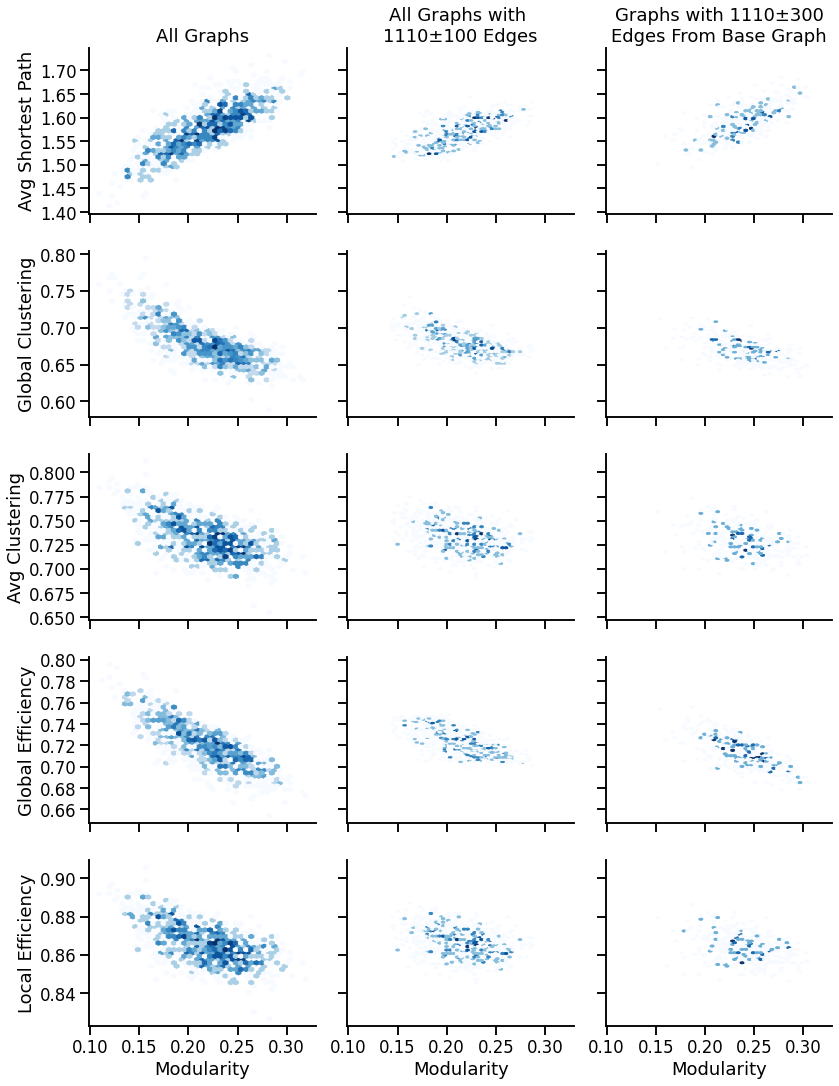

In [200]:
hexbin(
        df,
        df2,
        df3, 
        ORDERING, 
        #title=f"Base Graph Edges={num_edge}, Threshold=3, n={tmp.shape[0]}",
        ax1_title="All Graphs",
        ax2_title=f"All Graphs with \n1110±100 Edges",
        ax3_title=f"Graphs with 1110±300\nEdges From Base Graph",
        savefig=f"./exp6_hcp"
    )